In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [158]:
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation , Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.metrics import categorical_crossentropy 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, plot_roc_curve,accuracy_score, roc_curve,roc_auc_score
import itertools 
import shutil
import random
import glob
import matplotlib.pyplot as plt
import seaborn as sns

Code is used to list out GPU's available. This is useful if targeting GPU on personal machine and wanting to validate the proper TensorFlow setup is in place to utilize GPU. 

In [106]:
graphics=tf.config.experimental.list_physical_devices('GPU')
print("GPU's Available: ", len(graphics))

GPU's Available:  0


Iterating through the training directories to count the number of images in each emotion category. 

In [105]:
training_path = '/kaggle/input/fer2013/train'
test_path = '/kaggle/input/fer2013/test'
categories = ('angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise')
count = 0
print('Count of Image Files for Each Training Category')
print('-----------------------------------------------')
for e in categories:
    files = os.listdir(training_path + '/' + e)
    for f in files:
        count+=1
    print(e + ' : ' , count)
    count=0


Count of Image Files for Each Training Category
-----------------------------------------------
angry :  3995
disgust :  436
fear :  4097
happy :  7215
neutral :  4965
sad :  4830
surprise :  3171


Next two sections create the training and validation dataset batches which will be used to train the model. The validation split is used so that the model is not validated against the same data it is being trained with. Without creating this split and validating against unseen images the model could become overfit. Overfitting would produce high accuracy for the training but would perform poorly on unseen data for production. 

In [108]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  training_path,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(48,48),
  batch_size=30)


Found 28709 files belonging to 7 classes.
Using 22968 files for training.


In [109]:
validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
  training_path,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(48,48),
  batch_size=30)

Found 28709 files belonging to 7 classes.
Using 5741 files for validation.


Showing a random selection of images from the dataset to showcase what the images look like 

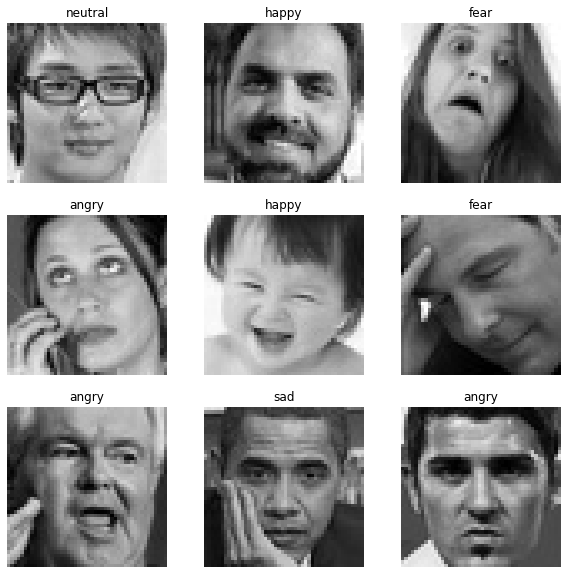

In [104]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(categories[labels[i]])
    plt.axis("off")


Building out a model with standard CNN architecture. Some important features are:
* Scaling - this is to normalize the values between 0 and 1. 255 is used because the dataset is grayscale. 
* Flatten- this takes a 3d image and converts to 1 d
* The last layer must have the same number of nodes as the categories being predicted. In this case it is 7. 

In [ ]:
model = Sequential()
model.add(Rescaling(1./255)),
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(7))



Second model to see how changes to the architecture affect the accuracy. 

In [123]:
model_2 = Sequential()
model_2.add(Rescaling(1./255)),
model_2.add(Conv2D(32, (3, 3), activation='softmax', input_shape=(48, 48, 1)))
model_2.add(MaxPool2D((2, 2)))
model_2.add(Conv2D(64, (3, 3), activation='softmax'))
model_2.add(MaxPool2D((2, 2)))
model_2.add(Conv2D(64, (3, 3), activation='softmax'))
model_2.add(Flatten())
model_2.add(Dense(64, activation='softmax'))
model_2.add(Dense(64, activation='softmax'))
model_2.add(Dense(64, activation='softmax'))
model_2.add(Dense(7))

Compiling the model. This is telling the model how to gauge improvement for epoch run in order to have a metric to base results against. 

In [ ]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])


In [124]:
model_2.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

training the model using the training dataset created and the validation dataset created. This will run for 50 epochs which essentially runs data through 50 times with each epoch building on the prior ones weights so that continous improvement of accuracy is achieved. There will be a tradeoff between the time it takes to run a certain number of epochs and the performance gained. There will also be a point where improvement is not made.  

To determine if gains are being made the scores prefixed with "Val" should be used. This is how well the model is predicting against unseen data residing in the validation set. If val_loss is increasing or Val_accuracy is not increasing then the model is not learning despite any performance gains that might be gained in the training accuracy metric. Based on this the epochs run will need modified. Or, if performance is not desirable, the architecture will of the model will need modified. It's also possible the data will need additional prepping. 

Using a variable to hold the history dictionary that is returned by the fit function epochs is useful for plotting metrics, comparing different models, and evalauating performance over epochs. 

In [120]:

history_log = model.fit(train_ds, validation_data=validation_ds,epochs=50)


Epoch 1/50
766/766 [==============================] - 63s 83ms/step - loss: 0.0862 - accuracy: 0.9739 - val_loss: 7.0272 - val_accuracy: 0.4862
Epoch 2/50
766/766 [==============================] - 63s 81ms/step - loss: 0.1121 - accuracy: 0.9650 - val_loss: 6.7544 - val_accuracy: 0.4895
Epoch 3/50
766/766 [==============================] - 62s 80ms/step - loss: 0.0881 - accuracy: 0.9710 - val_loss: 6.6761 - val_accuracy: 0.4916
Epoch 4/50
766/766 [==============================] - 63s 81ms/step - loss: 0.0810 - accuracy: 0.9737 - val_loss: 6.8548 - val_accuracy: 0.4860
Epoch 5/50
766/766 [==============================] - 63s 81ms/step - loss: 0.0956 - accuracy: 0.9704 - val_loss: 7.0076 - val_accuracy: 0.4882
Epoch 6/50
766/766 [==============================] - 64s 83ms/step - loss: 0.0926 - accuracy: 0.9705 - val_loss: 6.8147 - val_accuracy: 0.4978
Epoch 7/50
766/766 [==============================] - 62s 81ms/step - loss: 0.0795 - accuracy: 0.9730 - val_loss: 7.1097 - val_accuracy:

only 10 epochs for this model because the peformance was terrible. Cancled the first run and ran again with this limited set of epochs to show the peformance and lack of learning. 

In [126]:
history_log_2 = model_2.fit(train_ds, validation_data=validation_ds,epochs=10)

Epoch 1/10
766/766 [==============================] - 96s 125ms/step - loss: 1.8088 - accuracy: 0.2528 - val_loss: 1.8149 - val_accuracy: 0.2453
Epoch 2/10
766/766 [==============================] - 93s 121ms/step - loss: 1.8089 - accuracy: 0.2528 - val_loss: 1.8149 - val_accuracy: 0.2453
Epoch 3/10
766/766 [==============================] - 95s 124ms/step - loss: 1.8089 - accuracy: 0.2528 - val_loss: 1.8149 - val_accuracy: 0.2453
Epoch 4/10
766/766 [==============================] - 95s 124ms/step - loss: 1.8089 - accuracy: 0.2528 - val_loss: 1.8149 - val_accuracy: 0.2453
Epoch 5/10
766/766 [==============================] - 94s 122ms/step - loss: 1.8089 - accuracy: 0.2528 - val_loss: 1.8149 - val_accuracy: 0.2453
Epoch 6/10
766/766 [==============================] - 92s 120ms/step - loss: 1.8088 - accuracy: 0.2528 - val_loss: 1.8149 - val_accuracy: 0.2453
Epoch 7/10
766/766 [==============================] - 97s 126ms/step - loss: 1.8088 - accuracy: 0.2528 - val_loss: 1.8148 - val_ac

Creating test dataset batch

In [107]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_path,
  image_size=(48,48),
  batch_size=30)
  


Found 7178 files belonging to 7 classes.


Running the predict function on the test data set which has not been seen by the model. The model was trained on a different dataset. Running the prediction on an unseen dataset ensure the integrity of the model by measuring against unseen data. There is potential for overfitting during the model training which would not be caught otherwise. 

In [110]:
pred=model.predict(test_ds)

Showing the predictions as they are returned by **Model.Predict**. There is a row for each prediction result with 7 items in each row. These 7 items indicate the confidence score weight for each emotion category. The emotion category with the highest weight represent the ML algorithm prediction. (IE, most likely emotion representing that image) 

In [111]:
pred

array([[ 14.376717 , -41.329098 , -13.286204 , ..., -12.232655 ,
         23.566723 , -15.378941 ],
       [-41.50845  , -41.742226 ,  15.106714 , ..., -15.505285 ,
        -26.399603 ,  40.84493  ],
       [ 11.386495 ,   7.6634984,   4.515815 , ...,   3.6824875,
         -4.985957 , -18.17305  ],
       ...,
       [  7.153469 , -26.455383 ,   3.1741793, ...,  -6.0204964,
         18.931036 ,  -9.1184635],
       [-11.326929 , -46.43581  ,  20.837063 , ...,  -2.7474346,
         26.047846 ,  -5.26587  ],
       [  6.6499324, -13.34281  ,  11.015025 , ...,  -2.2168984,
         17.908674 ,   4.303299 ]], dtype=float32)

In [112]:
print(len(pred))

7178


This code section converts all of the prediction weights for each emotion into one choice represented by the highest weighted emotion. The max of the 7 weighted scores is found and the index returned. The index will correspond to the dictionary correlating a number to emotion string value. 

In [113]:
print(pred.shape)

pred_max=[]
for p in pred:
    
    position=list(p).index(max(p))
    pred_max.append(position)
print(pred_max)


(7178, 7)
[5, 6, 3, 5, 4, 3, 2, 4, 5, 4, 0, 4, 4, 4, 3, 6, 4, 3, 0, 2, 0, 4, 4, 3, 3, 2, 5, 3, 2, 4, 0, 4, 4, 4, 2, 0, 2, 4, 5, 0, 3, 3, 0, 5, 2, 6, 3, 0, 3, 3, 5, 6, 4, 5, 0, 3, 2, 6, 3, 3, 3, 3, 3, 3, 2, 0, 5, 5, 6, 3, 5, 3, 2, 2, 6, 3, 4, 5, 4, 3, 2, 3, 3, 2, 0, 5, 0, 5, 0, 3, 3, 5, 6, 3, 3, 3, 6, 4, 0, 4, 5, 3, 5, 3, 6, 4, 0, 6, 2, 0, 4, 5, 6, 5, 5, 2, 3, 4, 5, 3, 3, 4, 0, 6, 0, 4, 0, 4, 6, 4, 0, 6, 5, 3, 3, 4, 6, 5, 2, 0, 4, 3, 5, 3, 3, 6, 4, 3, 3, 6, 3, 5, 6, 3, 5, 4, 3, 2, 4, 3, 1, 6, 4, 6, 2, 4, 3, 2, 5, 3, 4, 4, 3, 0, 1, 3, 0, 3, 0, 3, 0, 5, 5, 3, 5, 5, 0, 3, 5, 3, 4, 2, 1, 3, 6, 0, 0, 2, 2, 3, 4, 0, 3, 0, 4, 5, 3, 3, 5, 4, 2, 2, 5, 0, 4, 2, 0, 4, 4, 4, 6, 4, 6, 2, 0, 5, 4, 6, 2, 0, 0, 5, 2, 3, 3, 4, 4, 4, 4, 5, 5, 0, 5, 0, 2, 4, 0, 4, 2, 2, 2, 5, 4, 0, 2, 3, 4, 5, 2, 5, 2, 4, 6, 0, 5, 2, 4, 4, 6, 3, 6, 4, 5, 3, 2, 3, 4, 3, 4, 0, 3, 2, 2, 5, 3, 2, 3, 4, 0, 6, 3, 3, 3, 3, 4, 3, 4, 3, 3, 2, 3, 3, 4, 5, 6, 0, 5, 2, 5, 6, 5, 2, 4, 4, 2, 6, 0, 3, 0, 5, 0, 5, 5, 3, 5, 3, 3, 5, 4, 4,

In [114]:
print(len(pred_max))

7178


In [115]:
test_labels=[]
for e in categories:
    files = os.listdir(test_path + '/' + e)
    for f in files:
        if e =="angry":
            test_labels.append(0)
        elif e=="disgust":
            test_labels.append(1)
        elif e=="fear":
            test_labels.append(2)
        elif e=="happy":
            test_labels.append(3)
        elif e=="neutral":
            test_labels.append(4)
        elif e=="sad":
            test_labels.append(5)
        elif e=="surprise":
            test_labels.append(6)
                            
            
        #test_labels.append(e)
print(test_labels)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

print(test_labels)

Saving the results of the predictions and corresponding labels into a pandas dataframe for easier use. 

In [117]:
test_results=pd.DataFrame(columns=["Prediction","Labels"])
test_results["Prediction"]=pred_max
test_results["Labels"]=test_labels


Saving the dataframe to file

In [118]:
test_results
test_results.to_csv("results.csv")

In [149]:
 print(history_log.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


Viewing accuracy for both models over the course of Epoch runs. This plots training scores vs validation scores. ROC (Receiver Operator Curve) would have been a nice added metric. However,with this being a multiclass problem, pairwise operations would need performed. This involves modeling one class as the positive and the rest as the negative. While this would have given some insight into the model, the work to accomplish this task would not be beneficial given the extreme difference in accuracy between these two models making selection of the best performing easy. 

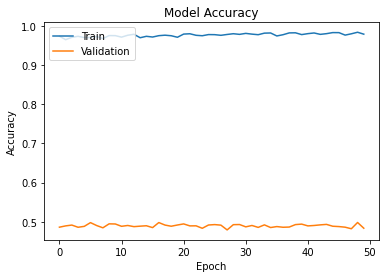

In [150]:
plt.plot(history_log.history['accuracy'])
plt.plot(history_log.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

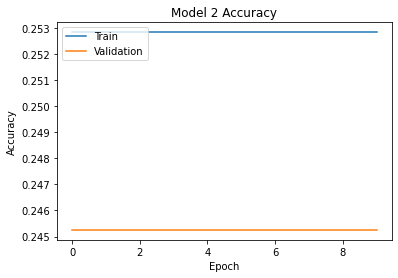

In [152]:
plt.plot(history_log_2.history['accuracy'])
plt.plot(history_log_2.history['val_accuracy'])
plt.title('Model 2 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

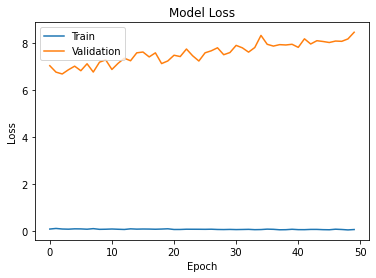

In [154]:
plt.plot(history_log.history['loss'])
plt.plot(history_log.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

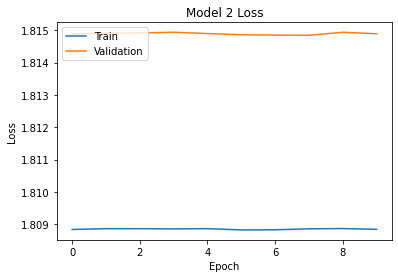

In [155]:
plt.plot(history_log_2.history['loss'])
plt.plot(history_log_2.history['val_loss'])
plt.title('Model 2 Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()